In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp


In [2]:
from funciones import get_farfield_radiant_intensity_percos_scalar, get_MA_farfield_phase_fun

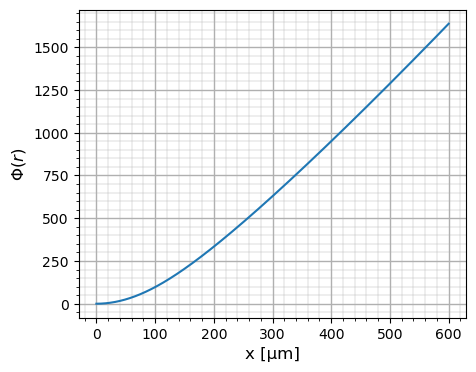

In [3]:
um = 1
mm = 1000*um
cm = 10000*um
w_alpha = np.sin(np.pi/6)
λ = 1.0*um
w_I = 200.0*um
n = 16


Nx = 2048*2
Ny = 2048*2

extent_r = 600*um

def target_fun(sinθ):
    return np.exp(-2*(((sinθ)/w_alpha))**n)

def input_fun(r):
    E = (np.where(r< extent_r,  np.exp(-(r**2)/(w_I**2)), 0))
    return E**2


Φ_fun,target_scale = get_MA_farfield_phase_fun(input_fun, target_fun, extent_r, λ)


def target_fun(sinθ):
    return target_scale*np.exp(-2*(((sinθ)/w_alpha))**n)




######################################################

fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(1,1,1)
r_ = np.linspace(0,extent_r, 500000)

ax.plot(r_/um, Φ_fun(r_) , '-')


ax.set_xlabel("x [μm]", size= 12)
ax.set_ylabel(r"$\Phi(r)$", size= 12)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)
ax.grid(which='minor', linestyle='-', linewidth=0.3)

plt.show()

Text(0, 0.5, 'PDE Residual')

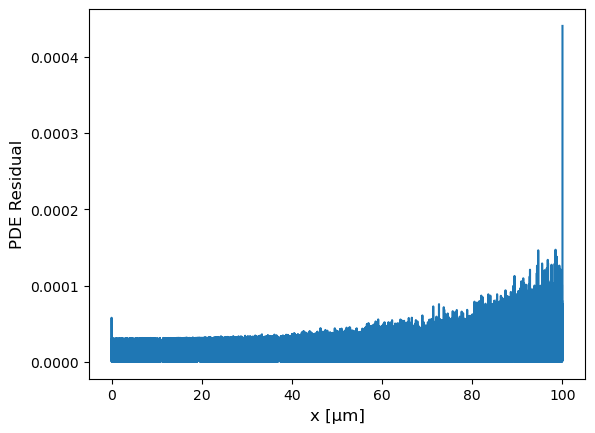

In [4]:
def verify_equation(L_fun, design_phase_fun, input_fun, lambda_, r_, tolerance=1e-6):
    # Evaluate phi(r) and its derivatives
    
    
    phi_r = design_phase_fun(r_)
    dphi_dr = np.gradient(phi_r, r_, edge_order=2)  # First derivative of phi
    d2phi_dr2 = np.gradient(dphi_dr, r_, edge_order=2)  # Second derivative of phi
    
    theta = (lambda_/(2*np.pi))  *  dphi_dr
    L_ = L_fun(theta)

    # Compute the left-hand side (LHS) of the equation
    lhs = L_ * (lambda_ / (2 * np.pi))**2 * dphi_dr * d2phi_dr2

    # Compute the right-hand side (RHS) of the equation
    rhs = input_fun(r_) * r_

    return np.abs(lhs - rhs)


r_ = np.linspace(0,100,100000)
plt.plot(r_, verify_equation(target_fun, Φ_fun, input_fun, λ, r_))
plt.xlabel("x [μm]", size= 12)
plt.ylabel(r"PDE Residual", size= 12)


# Campo Incidente

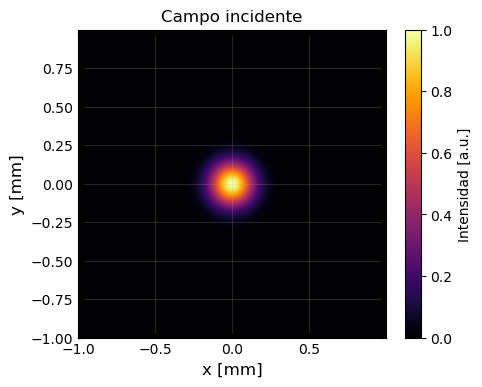

In [5]:
extent_x = extent_y = 2000*um

dx = extent_x/Nx
dy = extent_y/Ny
x = dx*(np.arange(Nx)-Nx//2)
y = dy*(np.arange(Ny)-Ny//2)
xx, yy = np.meshgrid(x, y)
rr = np.sqrt(xx**2 +  yy**2)
E = np.sqrt(input_fun(rr))*np.exp(1j*(Φ_fun(rr)  ))



fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(np.abs(E)**2, origin = 'lower', cmap ='inferno',    extent = [xx[0,0]/mm ,xx[0,-1]/mm ,yy[0,0]/mm ,yy[-1,0]/mm ])
cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label('Intensidad [a.u.]')
ax.set_title(r"Campo incidente")
ax.set_xlabel("x [mm]", size= 12)
ax.set_ylabel("y [mm]", size= 12)
plt.grid(alpha =0.2)
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)
plt.show()


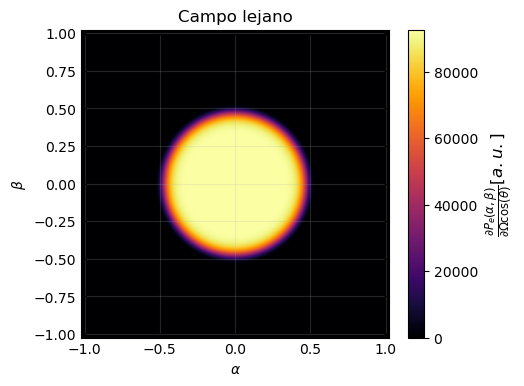

In [6]:
α, β, Irad = get_farfield_radiant_intensity_percos_scalar(x, y, E,λ)
fig = plt.figure(figsize=(5, 4))

ax = fig.add_subplot(1,1,1)

im = ax.imshow(2*np.abs(Irad), origin = 'lower', cmap ='inferno',    extent = [α[0],α[-1],β[0],β[-1]])


ax.set_xlabel('$α$')
ax.set_ylabel("$β$")


ax.set_title(r"Campo lejano")
ax.set_xlabel('$α$')
ax.set_ylabel("$β$")
plt.grid(alpha =0.2)
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)
#ax.set_xlim([-1, 1])
#ax.set_ylim([-1, 1])

cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label(r"$\frac{\partial P_e(α,β)}{\partial \Omega \cos(\theta)} [a.u.]$", size= 12)


plt.show()



/tmp/ipykernel_6230/4115607567.py:9: RuntimeWarning: invalid value encountered in arcsin
  ax.plot(np.arcsin(α) *180/ np.pi, Irad[Ny//2] , label = 'perfil simulado' )
/tmp/ipykernel_6230/4115607567.py:11: RuntimeWarning: invalid value encountered in arcsin
  ax.plot(np.arcsin(α) *180/ np.pi, 0.5*target, '--', label = 'perfil objetivo' )


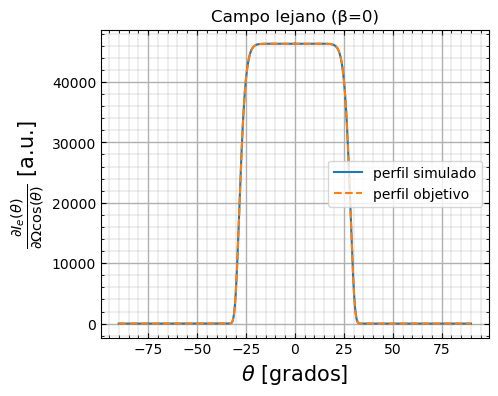

In [7]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)  
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)

target = target_fun(α)

ax.plot(np.arcsin(α) *180/ np.pi, Irad[Ny//2] , label = 'perfil simulado' )

ax.plot(np.arcsin(α) *180/ np.pi, 0.5*target, '--', label = 'perfil objetivo' ) 



ax.tick_params(axis='both', which="both", direction="in",right=True, top=True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)
ax.grid(which='minor', linestyle='-', linewidth=0.3)


plt.title('Campo lejano (β=0)')


#ax.set_title('super gaussian at MOE 1')
ax.set_ylabel(r'$\frac{\partial I_e(θ)}{\partial \Omega \cos(\theta)}$ [a.u.]', size= 15)
ax.set_xlabel(r'$\theta$ [grados]', size= 15)
plt.legend()
plt.show()

# Caso con $λ$ / $\omega_0$ = 0.25

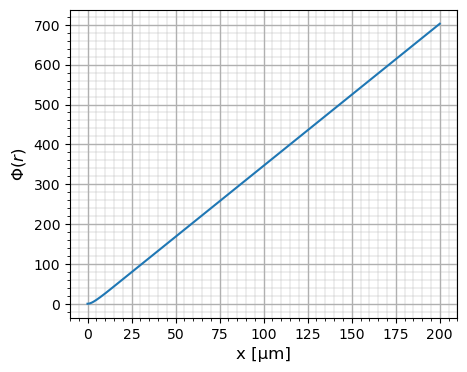

In [8]:
um = 1
mm = 1000*um
cm = 10000*um
w_alpha = np.sin(np.pi/6)
λ = 1.0*um
w_I = 4.0*um
n = 16


Nx = 2048*2
Ny = 2048*2

extent_x = extent_y = 400*um
extent_r = extent_x/2

def target_fun(sinθ):
    return np.exp(-2*(((sinθ)/w_alpha))**n)

def input_fun(r):
    E = (np.where(r< extent_r,  np.exp(-(r**2)/(w_I**2)), 0))
    return E**2


Φ_fun,target_scale = get_MA_farfield_phase_fun(input_fun, target_fun, extent_r, λ)


def target_fun(sinθ):
    return target_scale*np.exp(-2*(((sinθ)/w_alpha))**n)




######################################################

fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(1,1,1)
r_ = np.linspace(0,extent_r, 500000)

ax.plot(r_/um, Φ_fun(r_) , '-')


ax.set_xlabel("x [μm]", size= 12)
ax.set_ylabel(r"$\Phi(r)$", size= 12)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)
ax.grid(which='minor', linestyle='-', linewidth=0.3)

plt.show()

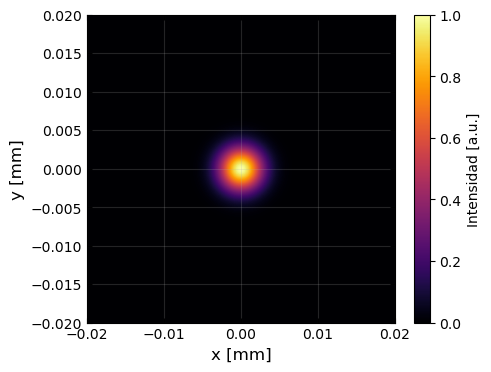

In [9]:
dx = extent_x/Nx
dy = extent_y/Ny
x = dx*(np.arange(Nx)-Nx//2)
y = dy*(np.arange(Ny)-Ny//2)
xx, yy = np.meshgrid(x, y)
rr = np.sqrt(xx**2 +  yy**2)
E = np.sqrt(input_fun(rr))*np.exp(1j*(Φ_fun(rr)  ))



fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(np.abs(E)**2, origin = 'lower', cmap ='inferno',    extent = [xx[0,0]/mm ,xx[0,-1]/mm ,yy[0,0]/mm ,yy[-1,0]/mm ])
cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label('Intensidad [a.u.]')
ax.set_xlabel("x [mm]", size= 12)
ax.set_ylabel("y [mm]", size= 12)
plt.grid(alpha =0.2)
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)
ax.set_xlim([-0.02, 0.02])
ax.set_ylim([-0.02, 0.02])

plt.show()


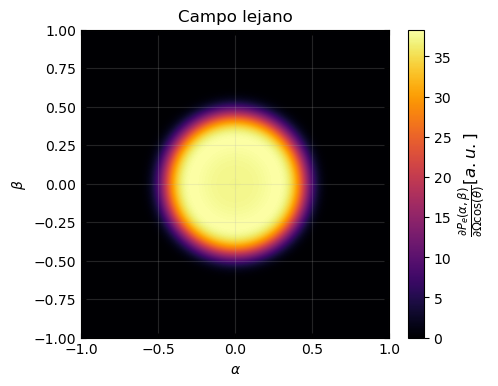

In [10]:
α, β, Irad = get_farfield_radiant_intensity_percos_scalar(x, y, E,λ)
fig = plt.figure(figsize=(5, 4))

ax = fig.add_subplot(1,1,1)

im = ax.imshow(2*np.abs(Irad), origin = 'lower', cmap ='inferno',    extent = [α[0],α[-1],β[0],β[-1]])


ax.set_xlabel('$α$')
ax.set_ylabel("$β$")


ax.set_title(r"Campo lejano")
ax.set_xlabel('$α$')
ax.set_ylabel("$β$")
plt.grid(alpha =0.2)
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label(r"$\frac{\partial P_e(α,β)}{\partial \Omega \cos(\theta)} [a.u.]$", size= 12)


plt.show()



/tmp/ipykernel_6230/4115607567.py:9: RuntimeWarning: invalid value encountered in arcsin
  ax.plot(np.arcsin(α) *180/ np.pi, Irad[Ny//2] , label = 'perfil simulado' )
/tmp/ipykernel_6230/4115607567.py:11: RuntimeWarning: invalid value encountered in arcsin
  ax.plot(np.arcsin(α) *180/ np.pi, 0.5*target, '--', label = 'perfil objetivo' )


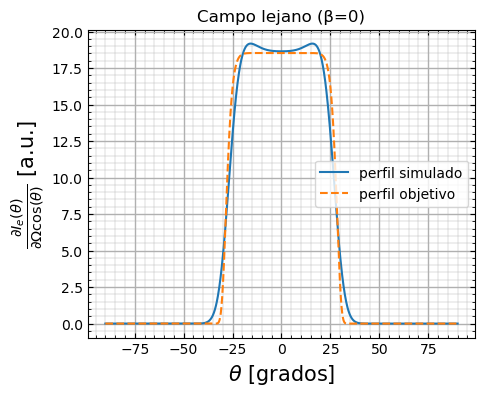

In [11]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)  
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)

target = target_fun(α)

ax.plot(np.arcsin(α) *180/ np.pi, Irad[Ny//2] , label = 'perfil simulado' )

ax.plot(np.arcsin(α) *180/ np.pi, 0.5*target, '--', label = 'perfil objetivo' ) 



ax.tick_params(axis='both', which="both", direction="in",right=True, top=True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=1.0)
ax.grid(which='minor', linestyle='-', linewidth=0.3)


plt.title('Campo lejano (β=0)')


#ax.set_title('super gaussian at MOE 1')
ax.set_ylabel(r'$\frac{\partial I_e(θ)}{\partial \Omega \cos(\theta)}$ [a.u.]', size= 15)
ax.set_xlabel(r'$\theta$ [grados]', size= 15)
plt.legend()
plt.show()